In [1]:
from functions import *
# Standards Librairies import
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

# Clustering Librairies import
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kmodes.kprototypes import KPrototypes

from functions import *
# Personnal scripts
#import olist_functions as fct

mpl.rcParams["figure.figsize"] = (15, 10)
init_notebook_mode()
warnings.filterwarnings('ignore')

# Functions

In [2]:
def select_col_by_type(df,col_type) : 
    var_object = []
    for col in df.select_dtypes(col_type) :
        var_object.append(col)
    return var_object


# Histogrammes des variables R,F et M

def hist_rfm(rfm) :
    fig = plt.figure(1, figsize=(15, 4))

    # Histogramme de la variable Recency
    plt.subplot(1, 3, 1)
    sns.distplot(rfm.Recency, label='Recency',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")

    # Histogramme de la variable Frequency
    plt.subplot(1, 3, 2)
    sns.distplot(rfm.Frequency, label='Frequency',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")

    # Histogramme de la variable Monetary
    plt.subplot(1, 3, 3)
    sns.distplot(rfm.Monetary, label='Monetary',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()

    
# Boxplot des variables R,F et M

def boxplot_rfm(rfm) :

    fig = plt.figure(1, figsize=(18, 4))

    # Boxplot de la variable Recency
    plt.subplot(131)
    sns.boxplot(rfm["Recency"], orient="vertical")

    # Boxplot de la variable Frequency
    plt.subplot(132)
    sns.boxplot(rfm["Frequency"], orient="vertical")

    # Boxplot de la variable Monetary
    plt.subplot(133)
    sns.boxplot(rfm["Monetary"], orient="vertical")
    plt.show()
    
    
    
def customer_cluster_rfm(rfm):
    """
    Retourne le segment associé au client en fonction de son score pour les
    variables R, F et M

    Paramètres:
    rfm(pd.DataFrame): doit contenir les colonnes R, F et M

    Return:
    str: Nom du segment
    """
    

    if 4 <= rfm["Recency"] <= 5 and 4 <= rfm["Frequency"] <= 5 and 4 <= rfm["Monetary"] <= 5:
        return "Champions"

    elif 3 <= rfm["Recency"] <= 5 and 3 <= rfm["Frequency"] <= 5 and 2 <= rfm["Monetary"] <= 5:
        return "Loyal Customers"

    elif 3 <= rfm["Recency"] <= 5 and 1 <= rfm["Frequency"] <= 3 and 1 <= rfm["Monetary"] <= 3:
        return "Potential Loyalist"

    elif rfm["Recency"] >= 4 and rfm["Frequency"] <= 2:
        return "Recent Customers"

    elif 3 <= rfm["Recency"] <= 4 and rfm["Frequency"] <= 1 and rfm["Monetary"] <= 1:
        return "Promising"

    elif 2 <= rfm["Recency"] <= 3 and 2 <= rfm["Frequency"] <= 3 and 2 <= rfm["Monetary"] <= 3:
        return "Need Attention"

    elif 2 <= rfm["Recency"] <= 3 and rfm["Frequency"] <= 2 and rfm["Monetary"] <= 2:
        return "About To Sleep"

    elif rfm["Recency"] <= 1 and 4 <= rfm["Frequency"] <= 5 and 4 <= rfm["Monetary"] <= 5:
        return "Can't Lose Them"

    elif rfm["Recency"] <= 2 and 2 <= rfm["Frequency"] <= 5 and 2 <= rfm["Monetary"] <= 5:
        return "At Risk"

    elif rfm["Recency"] <= 2 and rfm["Frequency"] <= 2 and rfm["Monetary"] <= 2:
        return "Lost"

    else:
        return "Others"

In [3]:
data_path = '../POLIST_kakpo_fiacre/data/'

In [4]:
# root path for cleaned dataset
df = pd.read_csv(data_path + "olist-customers-segm_EDA.csv",index_col=0)
df.head()

index                customer_unique_id  nb_orders  total_spend  \
0      0  0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
1      1  0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
2      2  0000f46a3911fa3c0805444483337064          1        86.22   
3      3  0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
4      4  0004aac84e0df4da2b147fca70cf8255          1       196.89   

   mean_payment_sequential  mean_payment_installments  mean_review_score  \
0                      1.0                        8.0                5.0   
1                      1.0                        1.0                4.0   
2                      1.0                        8.0                3.0   
3                      1.0                        4.0                4.0   
4                      1.0                        6.0                5.0   

   real_delivery_delay  favorite_sale_month  books_cds_media  ...  \
0                  6.0                    5              0.0  ...   
1                  3.0                    5              0.0  ...   
2                 26.0                    3              0.0  ...   
3                 20.0                   10              0.0  ...   
4                 13.0                   11              0.0  ...   

   groceries_food_drink  health_beauty  home_furniture  other  sport  \
0                   0.0            0.0             1.0    0.0    0.0   
1                   0.0            1.0             0.0    0.0    0.0   
2                   0.0            0.0             0.0    1.0    0.0   
3                   0.0            0.0             0.0    0.0    0.0   
4                   0.0            0.0             0.0    0.0    0.0   

   technology  toys_baby  total_items  order_mean_delay  freight_ratio  
0         0.0        0.0          1.0             111.0           0.08  
1         0.0        0.0          1.0             114.0           0.30  
2         0.0        0.0          1.0             537.0           0.20  
3         1.0        0.0          1.0             321.0           0.40  
4         1.0        0.0          1.0             288.0           0.09  

[5 rows x 22 columns]

In [5]:
data = df.copy()

In [6]:
fast_dataset_info(data)

Le jeu de données contient 93349 lignes et 22 colonnes,  0 lignes dupliquées
Taux de valeurs manquantes :  
freight_ratio                   0.0
order_mean_delay                0.0
customer_unique_id              0.0
nb_orders                       0.0
total_spend                     0.0
mean_payment_sequential         0.0
mean_payment_installments       0.0
mean_review_score               0.0
real_delivery_delay             0.0
favorite_sale_month             0.0
books_cds_media                 0.0
fashion_clothing_accessories    0.0
flowers_gifts                   0.0
groceries_food_drink            0.0
health_beauty                   0.0
home_furniture                  0.0
other                           0.0
sport                           0.0
technology                      0.0
toys_baby                       0.0
total_items                     0.0
index                           0.0
dtype: float64 valeurs vides


In [7]:
data.drop(["index"], axis=1, inplace=True)

In [8]:
float_var = select_col_by_type(data,'float')
int_var = select_col_by_type(data,'int')
object_var = select_col_by_type(data,'object')
numerical_features = float_var + int_var

In [9]:
numerical_features

['total_spend',
 'mean_payment_sequential',
 'mean_payment_installments',
 'mean_review_score',
 'real_delivery_delay',
 'books_cds_media',
 'fashion_clothing_accessories',
 'flowers_gifts',
 'groceries_food_drink',
 'health_beauty',
 'home_furniture',
 'other',
 'sport',
 'technology',
 'toys_baby',
 'total_items',
 'order_mean_delay',
 'freight_ratio',
 'nb_orders',
 'favorite_sale_month']

# Methode de segmentation RFM

In [10]:
rfm = data[['order_mean_delay', 'nb_orders', 'total_spend']]
rfm

order_mean_delay  nb_orders  total_spend
0                 111.0          1       141.90
1                 114.0          1        27.19
2                 537.0          1        86.22
3                 321.0          1        43.62
4                 288.0          1       196.89
...                 ...        ...          ...
93344             447.0          1      2067.42
93345             262.0          1        84.58
93346             568.0          1       112.46
93347             119.0          1       133.69
93348             484.0          1        71.56

[93349 rows x 3 columns]

In [11]:
rfm.columns=['Recency','Frequency', 'Monetary']

In [12]:
rfm['Recency'] = rfm['Recency'].astype(int)

In [13]:
rfm.head()

Recency  Frequency  Monetary
0      111          1    141.90
1      114          1     27.19
2      537          1     86.22
3      321          1     43.62
4      288          1    196.89

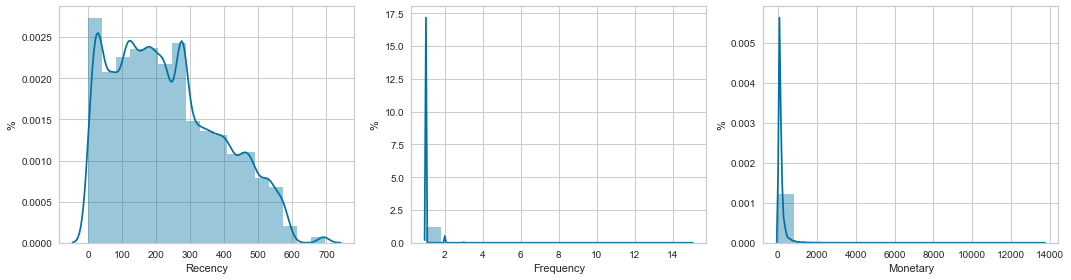

In [14]:
hist_rfm(rfm)

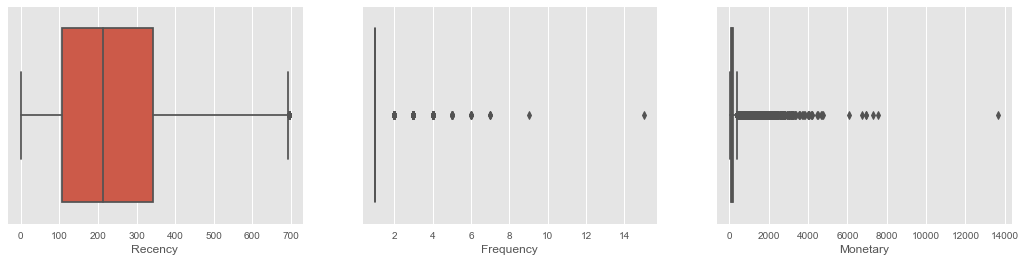

In [15]:
boxplot_rfm(rfm)

In [16]:
rfm['r_quartile'] = pd.qcut(rfm['Recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, ['4','3','2','1'])

In [17]:
#rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
#rfm.head()

In [18]:
#rfm["RFM cluster"] = rfm.apply(customer_cluster_rfm, axis=1)

In [19]:
rfm['RFM_Score'] = rfm[['r_quartile','f_quartile','m_quartile']].astype(int).sum(axis=1)
rfm['RFM_Score'].head()

0     8
1    10
2    11
3    11
4     8
Name: RFM_Score, dtype: int64

In [20]:
rfm['RFM_Score'].unique() 

array([ 8, 10, 11,  7, 12,  9,  6,  3,  4,  5])

In [21]:
#### Définir la fonction rfm_level 
def rfm_level(df): 
    if df['RFM_Score'] >= 9: 
        return 'Impossible de les perdre' 
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score']< 9)): 
        return 'Champions' 
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)): 
        return 'Loyal' 
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)) : 
        return 'Potentiel' 
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)) : 
        return 'Prometteur' 
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)): 
        return "Besoin dattention" 
    else : 
        return "Exiger une activation"


In [22]:

# Créer une nouvelle variable RFM_Level 
rfm['RFM_Cluster'] = rfm.apply(rfm_level, axis=1)
# Affiche l'en-tête avec les 5 premières lignes sur la console 
rfm.head(10)

Recency  Frequency  Monetary r_quartile f_quartile m_quartile  RFM_Score  \
0      111          1    141.90          2          4          2          8   
1      114          1     27.19          2          4          4         10   
2      537          1     86.22          4          4          3         11   
3      321          1     43.62          3          4          4         11   
4      288          1    196.89          3          4          1          8   
5      146          1    166.98          2          4          2          8   
6      131          1     35.38          2          4          4         10   
7      182          1    419.18          2          4          1          7   
8      543          1    150.12          4          4          2         10   
9      170          1    129.76          2          4          2          8   

                RFM_Cluster  
0                 Champions  
1  Impossible de les perdre  
2  Impossible de les perdre  
3  Impossible de les perdre  
4                 Champions  
5                 Champions  
6  Impossible de les perdre  
7                     Loyal  
8  Impossible de les perdre  
9                 Champions

In [23]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_cluster_agg = rfm.groupby('RFM_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)
# Print the aggregated dataset
print(rfm_cluster_agg)

                         Recency Frequency Monetary       
                            mean      mean     mean  count
RFM_Cluster                                               
Besoin dattention          85.41      1.19   296.54   4584
Champions                 250.34      1.00   139.52  17518
Exiger une activation      40.97      1.65   412.82   2629
Impossible de les perdre  334.35      1.00    86.95  30140
Loyal                     208.53      1.00   173.28  16610
Potentiel                 166.87      1.01   218.18  13487
Prometteur                122.59      1.05   249.14   8381


In [24]:
import squarify

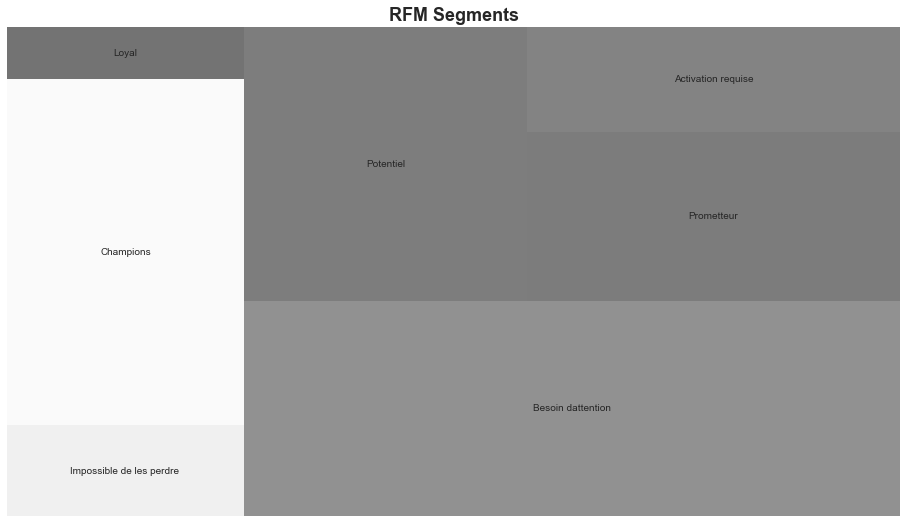

In [25]:
rfm_cluster_agg.columns = rfm_cluster_agg.columns.droplevel() 
rfm_cluster_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Créez notre intrigue et redimensionnez-la. 
fig = plt.gcf() 
ax = fig.add_subplot() 
fig.set_size_inches (16, 9)
squarify.plot(sizes=rfm_cluster_agg['Count'], 
              label=['Impossible de les perdre ', 
                     'Champions', 
                     'Loyal', 
                     'Besoin dattention', 
                     'Potentiel', 
                     'Prometteur', 
                     'Activation requise' ], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold") 
plt.axis('off') 
plt.show()


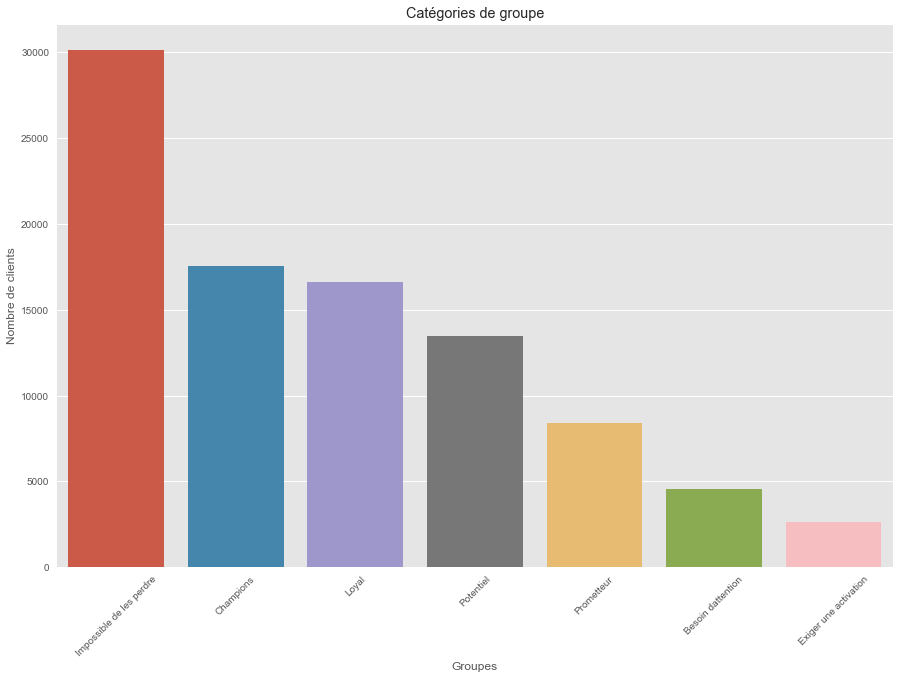

In [26]:
x = list(rfm["RFM_Cluster"].value_counts().index)
y = rfm["RFM_Cluster"].value_counts().values

plt.title("Catégories de groupe")
plt.xlabel("Groupes")
plt.xticks(rotation=45)

plt.ylabel("Nombre de clients")
sns.barplot(x, y)
plt.show()

In [27]:
def projection_2d_segments(data, xlabel, ylabel, label_score, colors) :
    """
    2D scatter plot
    data(pd.DataFrame): contient les 3 colonnes xlabel, ylabel et label_score
    xlabel(str): nom colonne data pour l'axe des x
    ylabel(str): nom colonnne data pour l'axe des y
    label_score: nom méthodologie de la segmentation
    """
    # Pour chaque segment, scatter plot
    for i, segment in enumerate(rfm[label_score].unique()):
        plt.scatter(data[data[label_score] == segment][xlabel],
                    data[data[label_score] == segment][ylabel],
                    label=segment,
                    c=colors[segment]
                   )
    # Titre des axes
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [28]:
categories_1 = ['Champions', 'Impossible de les perdre', 'Loyal', 'Potentiel',
       'Exiger une activation', 'Besoin dattention', 'Prometteur']

In [29]:
# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette("husl", len(categories_1))
colors_1 = {label: color for label, color in zip(categories_1,
                                                 palette_1.as_hex())}

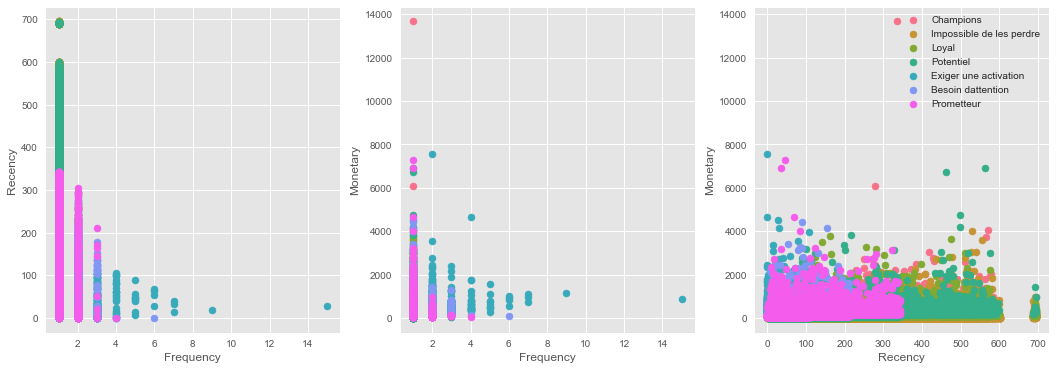

In [30]:
fig = plt.figure(1, figsize=(18, 6))

# 2D plot, Frequency vs Recency
plt.subplot(1, 3, 1)
projection_2d_segments(rfm,
                       "Frequency",
                       "Recency",
                       "RFM_Cluster",
                       colors=colors_1)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 2)
projection_2d_segments(rfm,
                       "Frequency",
                       "Monetary",
                       "RFM_Cluster",
                       colors=colors_1)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 3)
projection_2d_segments(rfm,
                       "Recency",
                       "Monetary",
                       "RFM_Cluster",
                       colors=colors_1)

plt.legend()

plt.show()

# K-means

## Preprocessing

In [31]:
scaler = MinMaxScaler()
preprocessor = ColumnTransformer([('scaler', scaler, numerical_features)])

# Méthode du coude : détermination du meilleur K


In [32]:
#Un pipeline SKLearn est créé pour y inclure le preprocessing et 
#la visualisation de la méthode du coude de notre KMeans.



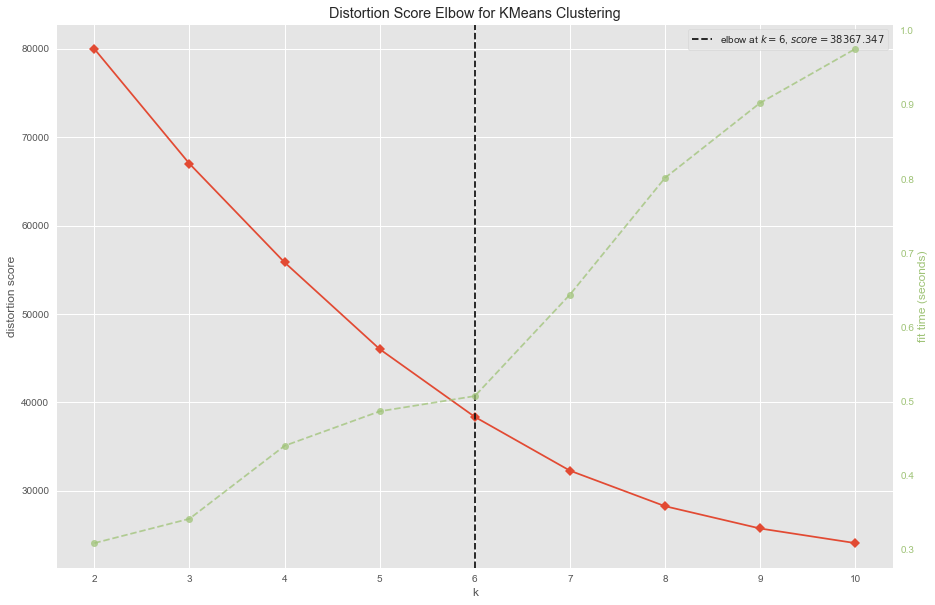

In [33]:
X = data.copy()
# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

## Coefficient de silhouette


In [34]:
# Pour vérifier si ce clustering fonctionne, 
# nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette 
# pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.

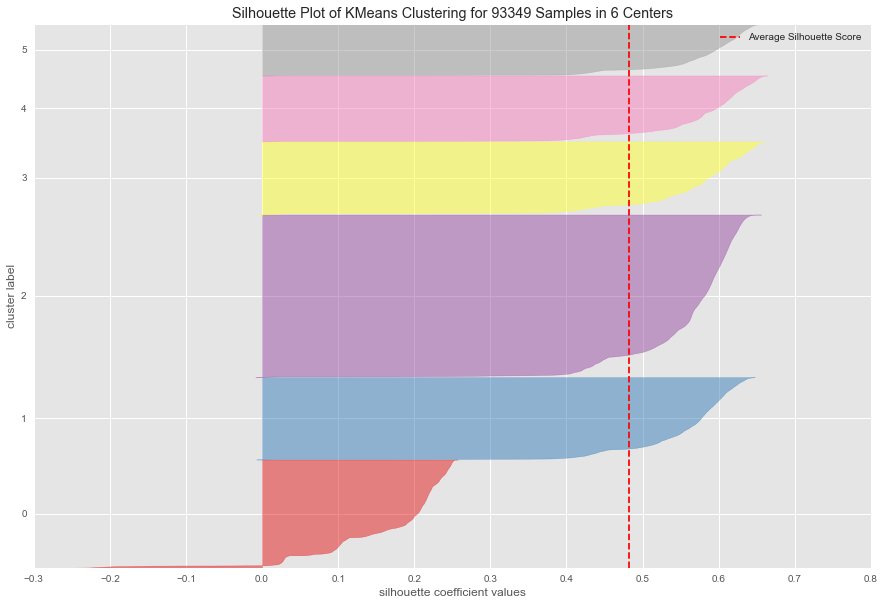

In [35]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

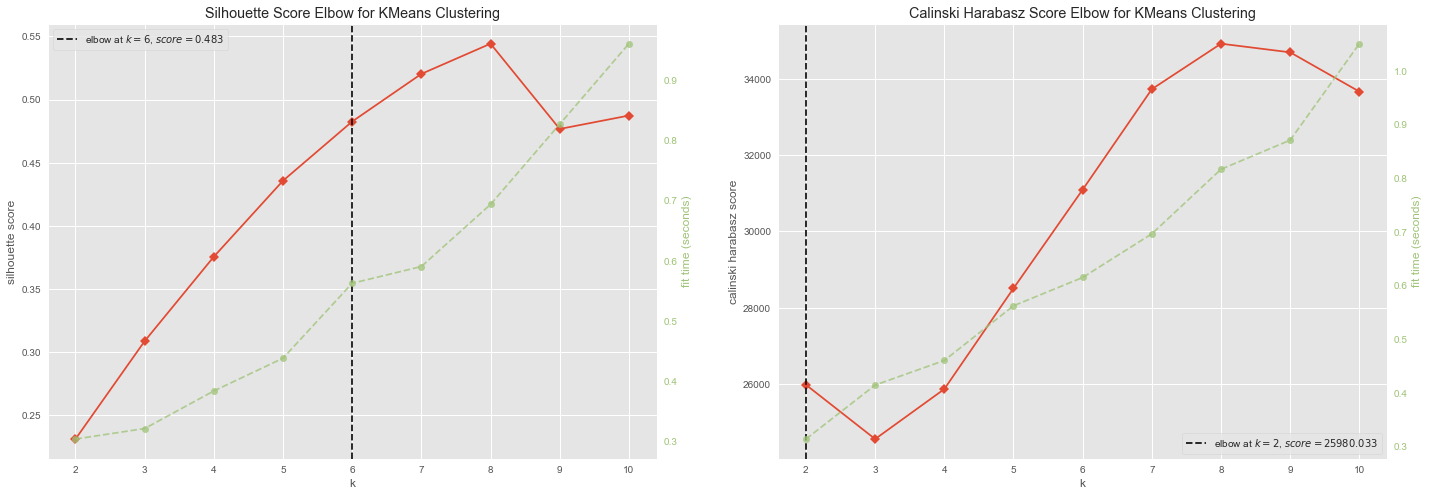

In [36]:
# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(4,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()

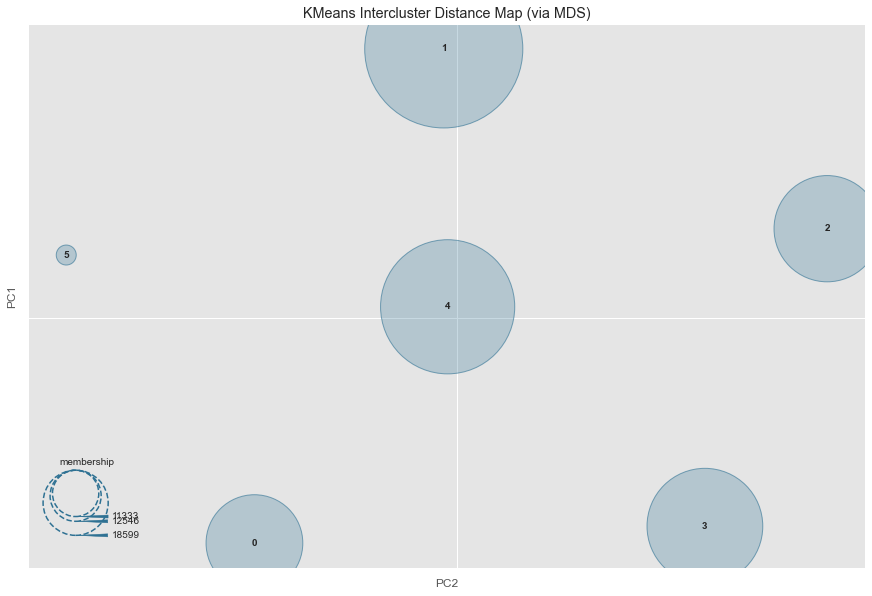

In [37]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [38]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data["kmeans_label"] = kmeans_labels

In [39]:
kmeans_clusters_means = data.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

kmeans_label  nb_orders  total_spend  mean_payment_sequential  \
0             0   1.022210   145.966367                 1.036379   
1             1   1.039944   163.712145                 1.055666   
2             2   1.029471   163.462156                 1.034317   
3             3   1.022642   221.331808                 1.041738   
4             4   1.041561   147.129150                 1.040280   
5             5   1.030595   178.979230                 1.041531   

   mean_payment_installments  mean_review_score  real_delivery_delay  \
0                   2.257580           4.080494            13.078336   
1                   3.289287           4.061183            12.977942   
2                   3.145320           4.235452            12.024442   
3                   3.636916           4.152903            12.645697   
4                   2.675033           4.222888            11.916309   
5                   2.843719           4.164863            12.158028   

   favorite_sale_month  books_cds_media  fashion_clothing_accessories  ...  \
0             5.692389         0.000035                      0.000674  ...   
1             6.045277         0.000137                      0.000702  ...   
2             6.059296         0.000176                      0.000588  ...   
3             6.271248         0.000114                      0.000796  ...   
4             6.256896         0.045020                      0.167981  ...   
5             5.859931         0.000199                      0.001175  ...   

   groceries_food_drink  health_beauty  home_furniture     other     sport  \
0              0.000224       0.000348        0.002173  0.000306  0.000018   
1              0.000159       0.000564        0.994371  0.001359  0.000194   
2              0.000606       0.993385        0.002846  0.000410  0.000099   
3              0.000023       0.000759        0.002579  0.000838  0.000061   
4              0.047729       0.001749        0.004034  0.001990  0.386100   
5              0.000116       0.001880        0.005458  0.987034  0.000127   

   technology  toys_baby  total_items  order_mean_delay  freight_ratio  
0    0.995701   0.000059     1.153699        236.491070       0.259926  
1    0.001146   0.000564     1.276459        237.095498       0.216115  
2    0.001191   0.000081     1.127592        222.055115       0.188541  
3    0.001688   0.000364     1.086472        234.536305       0.140049  
4    0.001503   0.341988     1.149470        242.487556       0.203666  
5    0.002154   0.000651     1.155685        211.014687       0.204145  

[6 rows x 21 columns]

In [40]:
X = X.drop(["customer_unique_id"], axis=1)

In [41]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

nb_orders  total_spend  mean_payment_sequential  \
kmeans_label                                                    
0              0.009988     0.001455                 0.086830   
1              0.011287     0.002227                 0.126511   
2              0.011269     0.001373                 0.120974   
3              0.015507     0.001670                 0.139881   
4              0.010073     0.001611                 0.102886   
5              0.012405     0.001661                 0.109374   

              mean_payment_installments  mean_review_score  \
kmeans_label                                                 
0                              0.770123           0.057791   
1                              0.765296           0.057311   
2                              0.808863           0.052749   
3                              0.788226           0.055721   
4                              0.805722           0.052231   
5                              0.791216           0.053388   

              real_delivery_delay  favorite_sale_month  books_cds_media  \
kmeans_label                                                              
0                        0.000035             0.000674         0.000462   
1                        0.000137             0.000702         0.000804   
2                        0.000176             0.000588         0.000618   
3                        0.000114             0.000796         0.992779   
4                        0.045020             0.167981         0.001907   
5                        0.000199             0.001175         0.001207   

              fashion_clothing_accessories  flowers_gifts  \
kmeans_label                                                
0                                 0.000224       0.000348   
1                                 0.000159       0.000564   
2                                 0.000606       0.993385   
3                                 0.000023       0.000759   
4                                 0.047729       0.001749   
5                                 0.000116       0.001880   

              groceries_food_drink  health_beauty  home_furniture     other  \
kmeans_label                                                                  
0                         0.002173       0.000306        0.000018  0.995701   
1                         0.994371       0.001359        0.000194  0.001146   
2                         0.002846       0.000410        0.000099  0.001191   
3                         0.002579       0.000838        0.000061  0.001688   
4                         0.004034       0.001990        0.386100  0.001503   
5                         0.005458       0.987034        0.000127  0.002154   

                 sport  technology  toys_baby  total_items  order_mean_delay  \
kmeans_label                                                                   
0             0.000059    0.006683   0.340275     0.270757          0.001586   
1             0.000564    0.012020   0.341145     0.225120          0.002853   
2             0.000081    0.005547   0.319504     0.196396          0.002105   
3             0.000364    0.003760   0.337462     0.145884          0.001617   
4             0.341988    0.006499   0.348903     0.212152          0.002969   
5             0.000651    0.006769   0.303618     0.212652          0.002185   

              freight_ratio  
kmeans_label                 
0                  0.426581  
1                  0.458662  
2                  0.459936  
3                  0.479204  
4                  0.477900  
5                  0.441812

In [42]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
   
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()


In [43]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

In [44]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']
X2 = X.drop(categories_col, axis=1)
X2.head()

nb_orders  total_spend  mean_payment_sequential  mean_payment_installments  \
0          1       141.90                      1.0                        8.0   
1          1        27.19                      1.0                        1.0   
2          1        86.22                      1.0                        8.0   
3          1        43.62                      1.0                        4.0   
4          1       196.89                      1.0                        6.0   

   mean_review_score  real_delivery_delay  favorite_sale_month  total_items  \
0                5.0                  6.0                    5          1.0   
1                4.0                  3.0                    5          1.0   
2                3.0                 26.0                    3          1.0   
3                4.0                 20.0                   10          1.0   
4                5.0                 13.0                   11          1.0   

   order_mean_delay  freight_ratio  
0             111.0           0.08  
1             114.0           0.30  
2             537.0           0.20  
3             321.0           0.40  
4             288.0           0.09

In [45]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

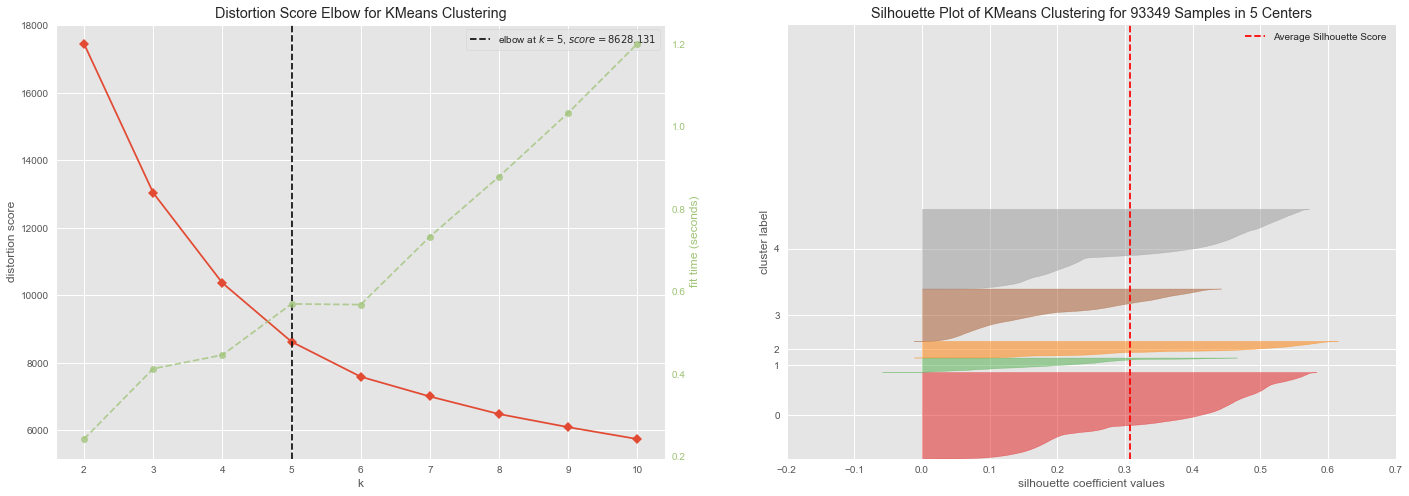

In [46]:
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X2, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None)

In [47]:
# KMeans Pipeline with best K
kmeans_model2 = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model2.fit(X2)

# Kmeans labels
kmeans_labels2 = kmeans_model2.named_steps['kmeans'].labels_

# Scale X
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)
X_scaled2 = pd.DataFrame(X_scaled2, index=X2.index, columns=X2.columns)
X_scaled2["kmeans_label"] = kmeans_labels2

# Group by cluster
X_scaled_clusters2 = X_scaled2.groupby("kmeans_label").mean()

# Plot Radar chart
plot_radars(data=X_scaled_clusters2,
            group="kmeans_label")


# Réduction dimensionnelle - PCA

In [49]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X2)
X_projected = pca.transform(X2)

### Eboulis des valeurs propres

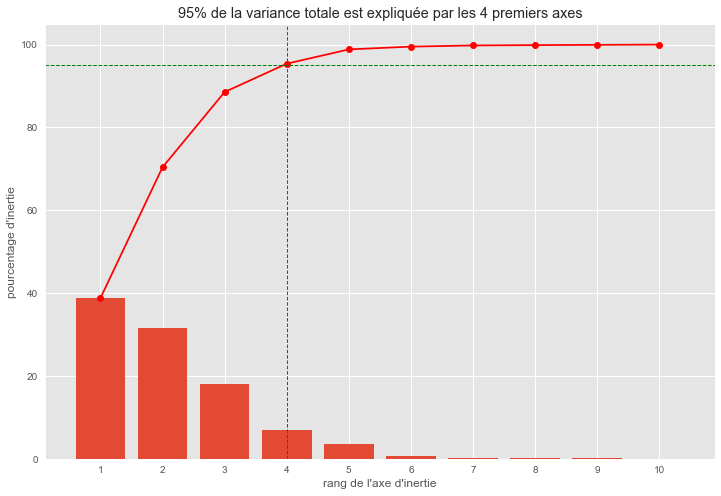

In [50]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

### Cercle de corrélation

In [51]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

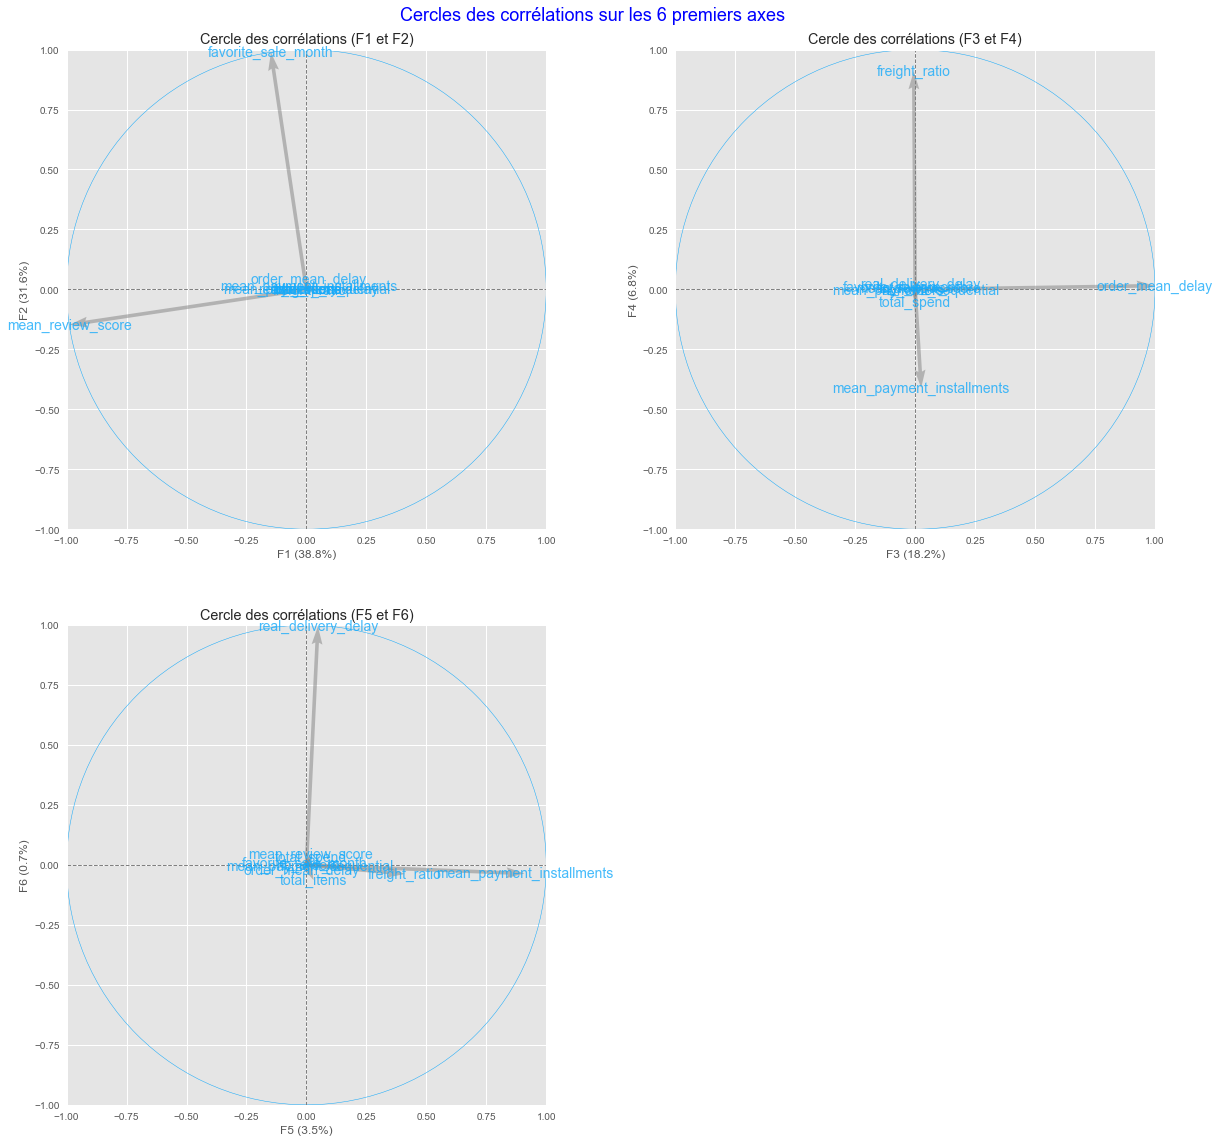

In [52]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           6,
           pca.named_steps['pca'],
           [(0,1),(2,3),(4,5)],
           labels = np.array(X2.columns))

### K-Means après réduction de dimenssions

In [53]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:4])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled2["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled2.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

nb_orders  total_spend  mean_payment_sequential  \
kmeans_label_pca                                                    
0                  0.005248     0.011776                 0.001483   
1                  0.001843     0.013468                 0.001892   
2                  0.000651     0.010812                 0.001707   
3                  0.000005     0.010856                 0.002373   
4                  0.002927     0.010758                 0.001596   

                  mean_payment_installments  mean_review_score  \
kmeans_label_pca                                                 
0                                  0.110244           0.904815   
1                                  0.123834           0.061856   
2                                  0.116312           0.892768   
3                                  0.122831           0.891016   
4                                  0.104749           0.886633   

                  real_delivery_delay  favorite_sale_month  total_items  \
kmeans_label_pca                                                          
0                            0.038503             0.504866     0.008984   
1                            0.091976             0.438221     0.015256   
2                            0.053590             0.836646     0.005456   
3                            0.051865             0.347618     0.004927   
4                            0.055830             0.136276     0.006754   

                  order_mean_delay  freight_ratio  
kmeans_label_pca                                   
0                         0.085578       0.219701  
1                         0.333786       0.222020  
2                         0.444723       0.211549  
3                         0.690851       0.218943  
4                         0.252966       0.214498

In [54]:
plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

5

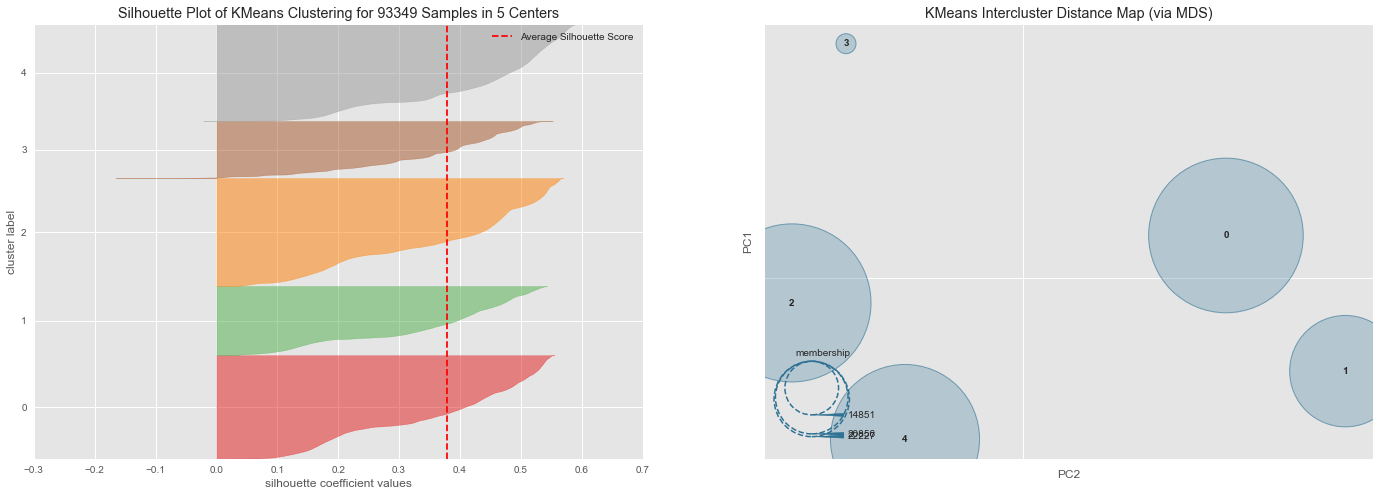

In [55]:
clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:4], 
                metric="distortion",
                elbow=False,
                mds=True,
                KBest=K)

# Stabilisation 

In [56]:
labels = pca_kmeans_labels
pca_data = X_projected[:,:4]

In [57]:
def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [58]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=pca_data, labels=labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.077s	6671	0.781	0.749	0.803
Iter 1   	0.063s	5482	1.000	1.000	1.000
Iter 2   	0.077s	6172	0.628	0.578	0.645
Iter 3   	0.078s	6030	0.686	0.604	0.720
Iter 4   	0.067s	5482	1.000	1.000	1.000
Iter 5   	0.075s	6190	0.607	0.555	0.621
Iter 6   	0.071s	6048	0.681	0.603	0.713
Iter 7   	0.065s	5482	1.000	1.000	1.000
Iter 8   	0.067s	6105	0.730	0.649	0.774
Iter 9   	0.065s	5482	1.000	1.000	1.000
_____________________________________________________


## Clustering avec l'algorithme du K-Prototypes

In [59]:
X_ter = X.iloc[:,:-1]
X_ter["favorite_sale_month"] = pd.to_datetime(X_ter["favorite_sale_month"], format='%m').dt.month_name()
X_ter["mean_payment_sequential"] = np.where(X_ter["mean_payment_sequential"] > 1, "Multiple", "Single")
X_ter["mean_payment_installments"] = np.where(X_ter["mean_payment_installments"] > 1, "Multiple", "Single")
X_ter.head()

nb_orders  total_spend mean_payment_sequential mean_payment_installments  \
0          1       141.90                  Single                  Multiple   
1          1        27.19                  Single                    Single   
2          1        86.22                  Single                  Multiple   
3          1        43.62                  Single                  Multiple   
4          1       196.89                  Single                  Multiple   

   mean_review_score  real_delivery_delay favorite_sale_month  \
0                5.0                  6.0                 May   
1                4.0                  3.0                 May   
2                3.0                 26.0               March   
3                4.0                 20.0             October   
4                5.0                 13.0            November   

   books_cds_media  fashion_clothing_accessories  flowers_gifts  \
0              0.0                           0.0            0.0   
1              0.0                           0.0            0.0   
2              0.0                           0.0            0.0   
3              0.0                           0.0            0.0   
4              0.0                           0.0            0.0   

   groceries_food_drink  health_beauty  home_furniture  other  sport  \
0                   0.0            0.0             1.0    0.0    0.0   
1                   0.0            1.0             0.0    0.0    0.0   
2                   0.0            0.0             0.0    1.0    0.0   
3                   0.0            0.0             0.0    0.0    0.0   
4                   0.0            0.0             0.0    0.0    0.0   

   technology  toys_baby  total_items  order_mean_delay  
0         0.0        0.0          1.0             111.0  
1         0.0        0.0          1.0             114.0  
2         0.0        0.0          1.0             537.0  
3         1.0        0.0          1.0             321.0  
4         1.0        0.0          1.0             288.0

In [60]:
for c in X_ter.select_dtypes(exclude="object").columns:
    scaler = MinMaxScaler()
    X_ter[c] = scaler.fit_transform(np.array(X_ter[c]).reshape(-1, 1))

In [61]:
# Categorical features index
cat_cols = [X_ter.columns.get_loc(c) for c in X_ter.select_dtypes(include="object").columns]


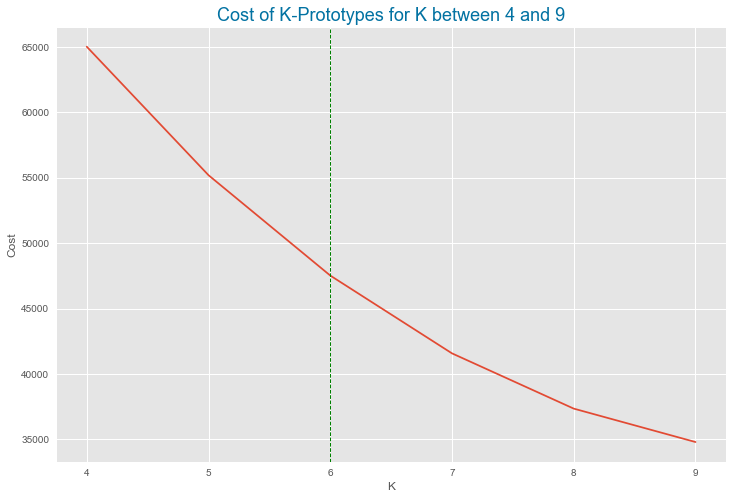

In [62]:
#Choosing optimal K
cost = []
for num_clusters in list(range(4,10)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(X_ter, categorical=cat_cols)
    cost.append(kproto.cost_)

plt.figure(figsize=(12,8))
plt.plot(cost)
plt.xticks(np.arange(0,6,1), np.arange(4,10,1))
plt.axvline(x=2, linestyle="--", 
            color="green",
            linewidth=1)
plt.xlabel("K")
plt.ylabel("Cost")
plt.title("Cost of K-Prototypes for K between 4 and 9",
          fontsize=18, color="b")
plt.show()

In [63]:
kproto = KPrototypes(n_clusters= 6, init='Cao')
kproto_labels = kproto.fit_predict(X_ter, categorical=cat_cols)


In [64]:
X_ter["kproto_labels"] = kproto_labels
X_ter.groupby("kproto_labels").mean()

nb_orders  total_spend  mean_review_score  real_delivery_delay  \
kproto_labels                                                                   
0               0.001672     0.015466           0.788640             0.055649   
1               0.002487     0.009632           0.806614             0.051240   
2               0.002559     0.011051           0.805912             0.053156   
3               0.003063     0.011323           0.766038             0.057297   
4               0.001949     0.012387           0.791524             0.053416   
5               0.001576     0.009987           0.769833             0.057811   

               books_cds_media  fashion_clothing_accessories  flowers_gifts  \
kproto_labels                                                                 
0                     0.000114                      0.000795       0.992163   
1                     0.073734                      0.275342       0.002280   
2                     0.000148                      0.000713       0.000697   
3                     0.000137                      0.000623       0.000713   
4                     0.000200                      0.001100       0.001225   
5                     0.000035                      0.000450       0.000498   

               groceries_food_drink  health_beauty  home_furniture     other  \
kproto_labels                                                                  
0                          0.000023       0.000303        0.002860  0.000780   
1                          0.077466       0.000765        0.004405  0.002083   
2                          0.000679       0.609419        0.002297  0.001593   
3                          0.000183       0.000402        0.993123  0.001760   
4                          0.000253       0.000181        0.004601  0.989069   
5                          0.000271       0.000454        0.001359  0.000624   

                  sport  technology  toys_baby  total_items  order_mean_delay  
kproto_labels                                                                  
0              0.001140    0.001629   0.000193     0.003799          0.337434  
1              0.000954    0.001153   0.561818     0.005545          0.354052  
2              0.383185    0.001206   0.000063     0.006414          0.328245  
3              0.001175    0.001554   0.000330     0.012120          0.340451  
4              0.001448    0.001830   0.000093     0.006620          0.304425  
5              0.000466    0.995713   0.000130     0.006680          0.340250

## Stabilité temporelle de la segmentation

In [65]:
# Initial period of 12 months
data_init = make_dataset(data_path, initial=True, period=2)

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 18.02s


In [66]:
# Remove categories
data_init.drop(categories_col, axis=1, inplace=True)
data_init.head()

nb_orders  total_items  total_spend  \
customer_unique_id                                                      
0000f46a3911fa3c0805444483337064          1            1        86.22   
0005e1862207bf6ccc02e4228effd9a0          1            1       150.12   
0006fdc98a402fceb4eb0ee528f6a8d4          1            1        29.00   
000a5ad9c4601d2bbdd9ed765d5213b3          1            1        91.28   
000de6019bb59f34c099a907c151d855          1            2       257.44   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000f46a3911fa3c0805444483337064                      1.0   
0005e1862207bf6ccc02e4228effd9a0                      1.0   
0006fdc98a402fceb4eb0ee528f6a8d4                      1.0   
000a5ad9c4601d2bbdd9ed765d5213b3                      1.0   
000de6019bb59f34c099a907c151d855                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000f46a3911fa3c0805444483337064                        8.0   
0005e1862207bf6ccc02e4228effd9a0                        3.0   
0006fdc98a402fceb4eb0ee528f6a8d4                        2.0   
000a5ad9c4601d2bbdd9ed765d5213b3                        3.0   
000de6019bb59f34c099a907c151d855                        4.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000f46a3911fa3c0805444483337064                3.0                26.0   
0005e1862207bf6ccc02e4228effd9a0                4.0                 4.0   
0006fdc98a402fceb4eb0ee528f6a8d4                3.0                16.0   
000a5ad9c4601d2bbdd9ed765d5213b3                4.0                11.0   
000de6019bb59f34c099a907c151d855                2.0                 2.0   

                                  favorite_sale_month  order_mean_delay  \
customer_unique_id                                                        
0000f46a3911fa3c0805444483337064                    3             178.0   
0005e1862207bf6ccc02e4228effd9a0                    3             184.0   
0006fdc98a402fceb4eb0ee528f6a8d4                    7              48.0   
000a5ad9c4601d2bbdd9ed765d5213b3                    8              24.0   
000de6019bb59f34c099a907c151d855                    8              18.0   

                                  freight_ratio  haversine_distance  
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064           0.20          125.363853  
0005e1862207bf6ccc02e4228effd9a0           0.10          428.916514  
0006fdc98a402fceb4eb0ee528f6a8d4           0.52          669.215559  
000a5ad9c4601d2bbdd9ed765d5213b3           0.16          337.899660  
000de6019bb59f34c099a907c151d855           0.11          209.713834

In [67]:
#olist_path = "../input/brazilian-ecommerce/"
orders = pd.read_csv(data_path+"olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


In [68]:
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [69]:
ari_score = []
for p in np.arange(2,(time_delta-12),2):
    # Create dataset for period
    data_period = make_dataset(data_path, 
                                   initial=False, 
                                   period=p)
    data_period.drop(categories_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 24.44s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 34.76s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequentia

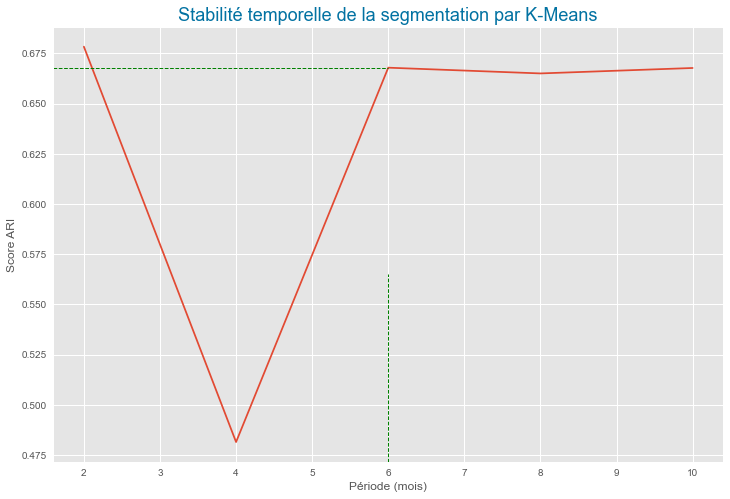

In [70]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()